In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

# from magicmethyl.magicmethyl import methylate
from magicmethyl.utils import show_analogs

In [3]:
CHI_TETRAHEDRAL_CW = Chem.ChiralType.CHI_TETRAHEDRAL_CW
CHI_TETRAHEDRAL_CCW = Chem.ChiralType.CHI_TETRAHEDRAL_CCW


def methylate(smi: str):
    """Generates all unique methylations including stereoisomers.

    Examples
    --------
    analogs = methylate('CC1CCCCC1')

    Parameters
    ----------
    smi: str
        The input SMILES string.

    Returns
    -------
    list[str]
        A list containing all unique methylations as SMILES strings."""
    mol = Chem.MolFromSmiles(smi)
    num_atoms = mol.GetNumAtoms()
    analogs = []

    for i, atom in enumerate(mol.GetAtoms()):
        # require the atom to be methylated has hydrogens
        if atom.GetTotalNumHs() > 0:
            # carbons are treated differently from heteroatoms due to stereochem
            if atom.GetAtomicNum() == 6:
                # use RWMol to edit the molecule
                analog = Chem.RWMol(mol)
                analog.AddAtom(Chem.Atom(6))
                analog.AddBond(i, num_atoms, Chem.BondType.SINGLE)
                # find if the atom has any other methyls on it
                has_methyls = False
                for neighbor in atom.GetNeighbors():
                    if (neighbor.GetSymbol() == 'C' and
                       neighbor.GetTotalNumHs() == 3):
                        has_methyls = True
                # if the atom is not sp3, there cannot be a stereocenter
                if (atom.GetHybridization() != Chem.HybridizationType.SP3 or
                   atom.GetTotalNumHs() == 3
                   or has_methyls):
                    analog = analog.GetMol()
                    analogs.append(Chem.MolToSmiles(analog))
                # if there is a possible stereocenter, we generate both possible
                #  mols and compare their SMILES strings to check for uniqueness
                else:
                    analog.GetAtomWithIdx(i).SetChiralTag(CHI_TETRAHEDRAL_CW)
                    cw_isomer = analog.GetMol()
                    analog.GetAtomWithIdx(i).SetChiralTag(CHI_TETRAHEDRAL_CCW)
                    ccw_isomer = analog.GetMol()
                    if (Chem.MolToSmiles(cw_isomer) ==
                       Chem.MolToSmiles(ccw_isomer)):
                        analogs.append(Chem.MolToSmiles(cw_isomer))
                    else:
                        analogs.append(Chem.MolToSmiles(cw_isomer))
                        analogs.append(Chem.MolToSmiles(ccw_isomer))
            # heteroatoms do not require a stereochem check
            if atom.GetAtomicNum() in [7, 8, 16]:
                analog = Chem.RWMol(mol)
                analog.AddAtom(Chem.Atom(6))
                analog.AddBond(i, num_atoms, Chem.BondType.SINGLE)
                analog = analog.GetMol()
                analogs.append(Chem.MolToSmiles(analog))

    return list(set(analogs))


there are 9 analogs

CCCc1cc2c(=O)ccoc2c(C)c1OC(C)=O


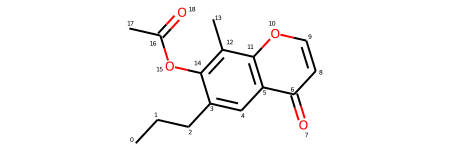

CCCc1cc2c(=O)cc(C)oc2cc1OC(C)=O


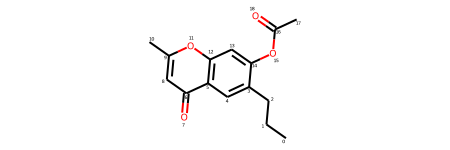

CC[C@@H](C)c1cc2c(=O)ccoc2cc1OC(C)=O


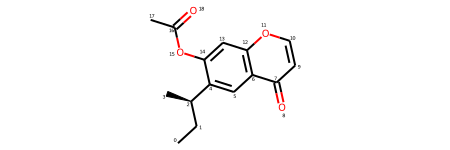

CCCc1cc2c(=O)ccoc2cc1OC(=O)CC


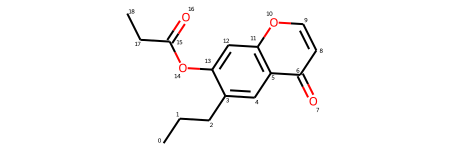

CCCCc1cc2c(=O)ccoc2cc1OC(C)=O


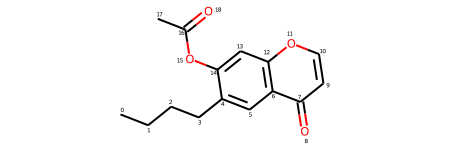

CC[C@H](C)c1cc2c(=O)ccoc2cc1OC(C)=O


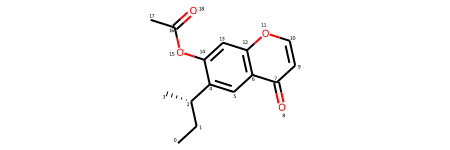

CC(=O)Oc1cc2occc(=O)c2cc1CC(C)C


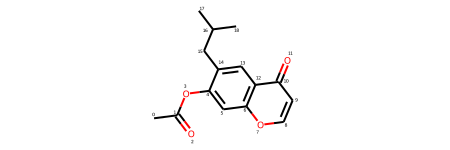

CCCc1c(OC(C)=O)cc2occc(=O)c2c1C


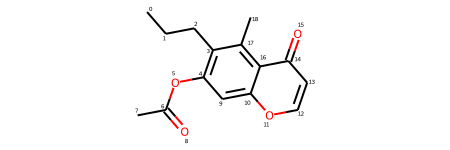

CCCc1cc2c(=O)c(C)coc2cc1OC(C)=O


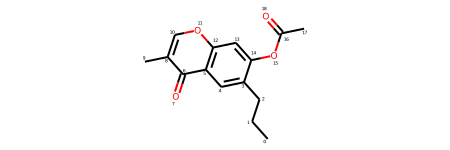

In [4]:
smi = 'CCCC1=CC2=C(OC=CC2=O)C=C1OC(C)=O'
show_analogs(methylate(smi))

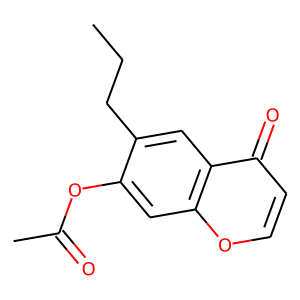

In [6]:
Chem.Draw.MolToImage(Chem.MolFromSmiles(smi))